In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import warnings
warnings.filterwarnings("ignore")


In [2]:
import zipfile
zip_path = "onlret_transaction.zip"
with zipfile.ZipFile(zip_path, "r") as z:
    # Lấy file CSV đầu tiên
    csv_name = next(f for f in z.namelist() if f.endswith(".csv"))
    with z.open(csv_name) as f:
        df = pd.read_csv(f, dtype={"CustomerID":str, "InvoiceNo":str})
df.head(2)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Status,CustomerType
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1,1
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1,1


In [3]:
df.isna().sum()

InvoiceNo            0
StockCode            0
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
TotalPrice           0
Status               0
CustomerType         0
dtype: int64

### Phân tích tổng quan tình hình theo mức độ chi tiêu

In [4]:
df1 = df.groupby("CustomerID").agg(sum_revenue = ("TotalPrice", "sum")).reset_index();

In [5]:
df1 = df1[(df1.sum_revenue>0)&(~df1.CustomerID.isna())&(df1.sum_revenue<20000)]

In [6]:
sns.set_theme(style="whitegrid")

def plot_revenue_distribution_story(df1, revenue_col="sum_revenue", id_col="CustomerID",
                                    top_percents=(0.01, 0.05, 0.10), bins=40):
    """
    Vẽ distribution sum_revenue theo CustomerID theo hướng data storytelling.
    Returns:
        per_cust (DataFrame): doanh thu theo từng CustomerID
        insight (dict): thống kê chính để đưa vào report
    """

    # ---- Validate input ----
    if df1 is None or len(df1) == 0:
        raise ValueError("df1 rỗng hoặc None.")

    if id_col not in df1.columns or revenue_col not in df1.columns:
        raise ValueError(f"df1 phải có cột '{id_col}' và '{revenue_col}'. Hiện có: {list(df1.columns)}")

    # ---- Chuẩn hoá dữ liệu ----
    d = df1[[id_col, revenue_col]].copy()
    d = d.dropna(subset=[id_col, revenue_col])

    d[revenue_col] = pd.to_numeric(d[revenue_col], errors="coerce")
    d = d.dropna(subset=[revenue_col])

    # Group theo CustomerID (phòng trường hợp df1 có nhiều dòng/khách)
    per_cust = d.groupby(id_col, as_index=False)[revenue_col].sum()

    # Nếu có doanh thu âm và bạn muốn loại:
    # per_cust = per_cust[per_cust[revenue_col] >= 0]

    x = per_cust[revenue_col].to_numpy()

    if x.size == 0:
        raise ValueError("Sau khi làm sạch dữ liệu, không còn giá trị sum_revenue nào để vẽ.")

    # ---- Stats kể chuyện ----
    n = int(x.size)
    mean = float(np.mean(x))
    median = float(np.median(x))
    p90, p95, p99 = [float(v) for v in np.percentile(x, [90, 95, 99])]

    total = float(x.sum()) if float(x.sum()) != 0 else 1.0
    x_sorted = np.sort(x)[::-1]
    cum_share = np.cumsum(x_sorted) / total

    top_info = []
    for tp in top_percents:
        k = max(1, int(np.ceil(tp * n)))
        share = float(x_sorted[:k].sum() / total)
        top_info.append((tp, k, share))

    # mốc 80%
    k80 = int(np.searchsorted(cum_share, 0.8) + 1)

    # ---- Plot 2x2 ----
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(2, 2, wspace=0.25, hspace=0.30)

    # (A) Histogram linear + KDE
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(x, bins=bins, kde=True, ax=ax1, color="#2E86AB", edgecolor="white")
    ax1.axvline(median, color="#E74C3C", linestyle="--", linewidth=2, label=f"Median: {median:,.0f}")
    ax1.axvline(p90, color="#F39C12", linestyle="--", linewidth=2, label=f"P90: {p90:,.0f}")
    ax1.set_title("Phân phối doanh thu/khách hàng (thang tuyến tính)", fontsize=13, weight="bold")
    ax1.set_xlabel(revenue_col)
    ax1.set_ylabel("Số khách hàng")
    ax1.legend(loc="upper right")

    # (B) Histogram log1p
    ax2 = fig.add_subplot(gs[0, 1])
    x_log = np.log1p(x)  # log(1+x) an toàn cho 0
    sns.histplot(x_log, bins=bins, kde=True, ax=ax2, color="#5DA271", edgecolor="white")
    ax2.set_title("Phân phối doanh thu/khách hàng (log1p) — thấy rõ 'đuôi dài'", fontsize=13, weight="bold")
    ax2.set_xlabel(f"log1p({revenue_col})")
    ax2.set_ylabel("Số khách hàng")

    # (C) Boxplot
    ax3 = fig.add_subplot(gs[1, 0])
    sns.boxplot(x=x, ax=ax3, color="#A7C7E7")
    ax3.set_title("Boxplot doanh thu/khách — median, IQR và outliers", fontsize=13, weight="bold")
    ax3.set_xlabel(revenue_col)

    # (D) Cumulative share
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(np.arange(1, n + 1), cum_share, color="#6C5CE7", linewidth=2)
    ax4.set_title("Tích luỹ đóng góp doanh thu (xếp hạng khách theo doanh thu giảm dần)", fontsize=13, weight="bold")
    ax4.set_xlabel("Số khách hàng (từ top xuống)")
    ax4.set_ylabel("Tỷ trọng doanh thu tích luỹ")

    ax4.axhline(0.8, color="#E74C3C", linestyle="--", linewidth=1.5)
    ax4.axvline(k80, color="#E74C3C", linestyle="--", linewidth=1.5)
    ax4.text(k80, 0.02, f"~{k80} khách đạt 80% DT", color="#E74C3C", rotation=90,
             va="bottom", ha="right", fontsize=10)

    for tp, k, share in top_info:
        ax4.scatter([k], [share], color="#00B894", s=50, zorder=3)
        ax4.text(k, share, f"Top {int(tp*100)}% ({k} khách): {share*100:.1f}%",
                 fontsize=10, va="bottom", ha="left", color="#00B894")

    subtitle = (f"N={n:,} khách | Mean={mean:,.0f} | Median={median:,.0f} | "
                f"P90={p90:,.0f} | P95={p95:,.0f} | P99={p99:,.0f}")
    fig.suptitle("Distribution của tổng doanh thu theo mỗi khách hàng - nhìn cả 'đám đông' và 'khách VIP'",
                 fontsize=16, weight="bold", y=0.98)
    fig.text(0.5, 0.94, subtitle, ha="center", fontsize=11, color="#444444")

    plt.show()

    insight = {
        "n_customers": n,
        "mean": mean,
        "median": median,
        "p90": p90,
        "p95": p95,
        "p99": p99,
        "k80_customers": k80,
        "top_shares": {f"top_{int(tp*100)}%": share for tp, k, share in top_info}
    }

    return per_cust, insight

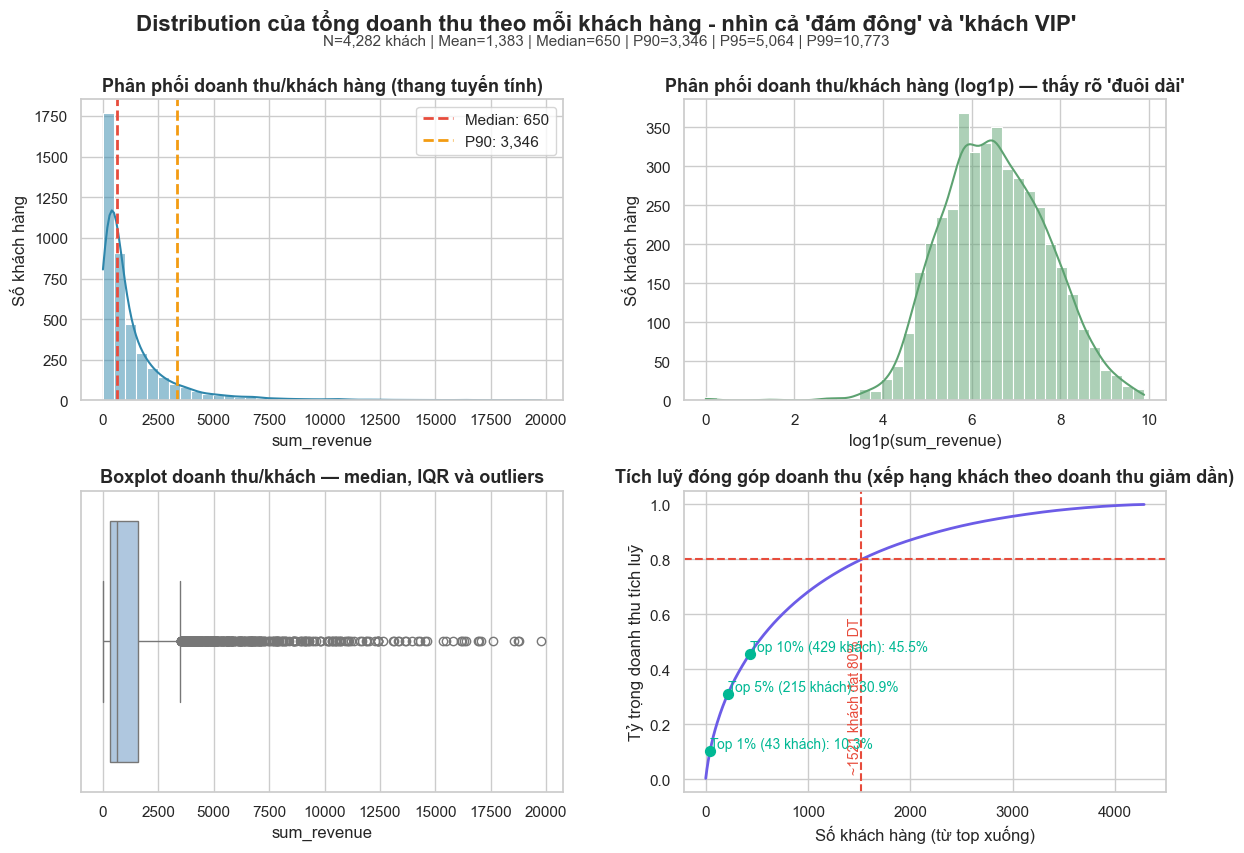

In [7]:
per_cust_df, insight = plot_revenue_distribution_story(df1)

In [8]:
insight

{'n_customers': 4282,
 'mean': 1383.2282774404482,
 'median': 650.4300000000001,
 'p90': 3346.1160000000004,
 'p95': 5063.7755,
 'p99': 10773.298199999923,
 'k80_customers': 1521,
 'top_shares': {'top_1%': 0.10271254877603507,
  'top_5%': 0.3089711536328843,
  'top_10%': 0.4552746090351922}}

In [9]:
def tier_customers_bronze_silver_gold(
    df1,
    id_col="CustomerID",
    rev_col="sum_revenue",
    gold_top=0.01,   # top 1%
    silver_top=0.05, # top 5% (bao gồm gold); silver là (gold, silver_top]
    tie_break="include_all"  # "include_all" hoặc "strict_rank"
):
    """
    Phân hạng khách hàng theo doanh thu:
      - Vàng: top 1%
      - Bạc: >1% đến <=5% (loại Vàng)
      - Đồng: còn lại

    tie_break:
      - "include_all": nếu nhiều khách có revenue bằng đúng ngưỡng (boundary) thì cho vào nhóm trên để không tách đôi bằng nhau.
      - "strict_rank": cắt đúng theo số lượng top% (k khách), dù bằng nhau vẫn bị chia.
    """

    # --- 0) Chuẩn hoá dữ liệu: revenue theo CustomerID ---
    d = df1[[id_col, rev_col]].copy()
    d = d.dropna(subset=[id_col, rev_col])
    d[rev_col] = pd.to_numeric(d[rev_col], errors="coerce")
    d = d.dropna(subset=[rev_col])

    per = d.groupby(id_col, as_index=False)[rev_col].sum()
    per = per.sort_values(rev_col, ascending=False).reset_index(drop=True)

    n = len(per)
    if n == 0:
        raise ValueError("Không có dữ liệu hợp lệ để phân hạng (n=0).")

    # --- 1) Xác định ngưỡng ---
    if tie_break == "strict_rank":
        k_gold = max(1, int(np.ceil(gold_top * n)))
        k_top5 = max(k_gold, int(np.ceil(silver_top * n)))

        gold_threshold = per.loc[k_gold - 1, rev_col]
        top5_threshold = per.loc[k_top5 - 1, rev_col]

        # strict: dùng rank theo thứ tự để cắt đúng k
        per["rank_desc"] = np.arange(1, n + 1)  # 1..n
        per["Tier"] = np.where(per["rank_desc"] <= k_gold, "Gold",
                        np.where(per["rank_desc"] <= k_top5, "Silver", "Bronze"))

    else:
        # include_all: dùng quantile threshold, ai >= threshold thì vào nhóm trên
        # Ngưỡng top 1% = percentile 99
        gold_threshold = per[rev_col].quantile(1 - gold_top)
        top5_threshold = per[rev_col].quantile(1 - silver_top)

        per["Tier"] = np.where(per[rev_col] >= gold_threshold, "Gold",
                        np.where(per[rev_col] >= top5_threshold, "Silver", "Bronze"))

    # --- 2) Tóm tắt số lượng & tỷ trọng ---
    total_rev = per[rev_col].sum() if per[rev_col].sum() != 0 else 1.0

    summary = (per.groupby("Tier")
                 .agg(customers=(id_col, "nunique"),
                      revenue=(rev_col, "sum"),
                      min_rev=(rev_col, "min"),
                      median_rev=(rev_col, "median"),
                      max_rev=(rev_col, "max"))
                 .reset_index())

    summary["customer_share_%"] = 100 * summary["customers"] / n
    summary["revenue_share_%"] = 100 * summary["revenue"] / total_rev

    # sắp tier theo thứ tự mong muốn
    order = pd.Categorical(summary["Tier"], categories=["Gold", "Silver", "Bronze"], ordered=True)
    summary = summary.assign(_order=order).sort_values("_order").drop(columns="_order").reset_index(drop=True)

    meta = {
        "n_customers": n,
        "gold_top_%": gold_top * 100,
        "silver_top_%": silver_top * 100,
        "gold_threshold": float(gold_threshold),
        "top5_threshold": float(top5_threshold),
        "tie_break": tie_break
    }

    return per, summary, meta

In [10]:
per_cust_tiered, tier_summary, meta = tier_customers_bronze_silver_gold(df1)

In [11]:
per_cust_tiered.head()

,CustomerID,sum_revenue,Tier
0,15039,19786.44,Gold
1,12731,18793.41,Gold
2,12471,18740.92,Gold
3,15159,18573.68,Gold
4,12678,17588.26,Gold


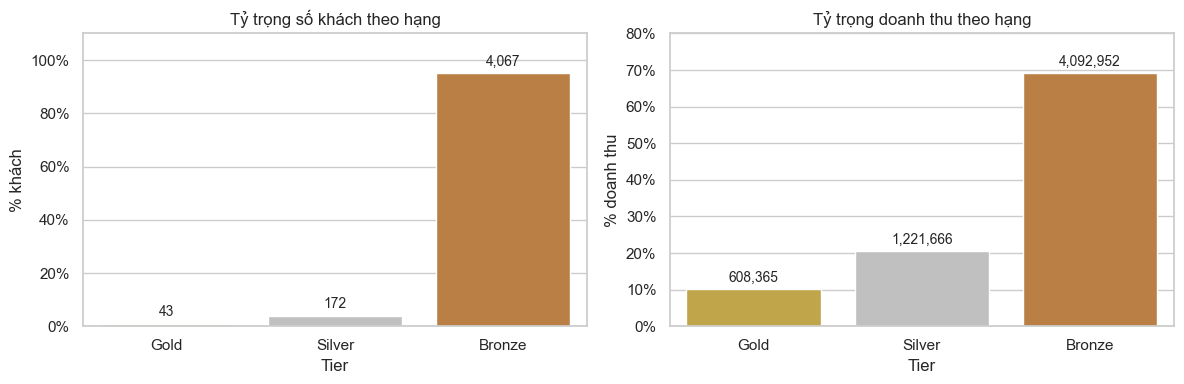

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")

plot_df = tier_summary.copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1) % khách
ax0 = axes[0]
sns.barplot(data=plot_df, x="Tier", y="customer_share_%", ax=ax0,
            palette=["#D4AF37", "#C0C0C0", "#CD7F32"])
ax0.set_title("Tỷ trọng số khách theo hạng")
ax0.set_ylabel("% khách")
ax0.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))

for i, p in enumerate(ax0.patches):
    value = plot_df.loc[i, "customers"]
    ax0.annotate(f"{int(value):,}",
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha="center", va="bottom", fontsize=10,
                 xytext=(0, 3), textcoords="offset points")

# 2) % doanh thu
ax1 = axes[1]
sns.barplot(data=plot_df, x="Tier", y="revenue_share_%", ax=ax1,
            palette=["#D4AF37", "#C0C0C0", "#CD7F32"])
ax1.set_title("Tỷ trọng doanh thu theo hạng")
ax1.set_ylabel("% doanh thu")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))

for i, p in enumerate(ax1.patches):
    value = plot_df.loc[i, "revenue"]
    ax1.annotate(f"{value:,.0f}",
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha="center", va="bottom", fontsize=10,
                 xytext=(0, 3), textcoords="offset points")

ax0.set_ylim(0,110)
ax1.set_ylim(0,80)
plt.tight_layout()
plt.show()

In [13]:
per_cust_tiered.to_csv("tier_customer.csv", index=False)

### Phân tích để phân loại khách hàng sỉ và lẻ

In [14]:
df2 = df.groupby("CustomerID").agg(sum_revenue=("TotalPrice", "sum"), sum_quantity=("Quantity", "sum"), cnt_bill=("InvoiceNo", "nunique")).reset_index()

In [15]:
df2.head(2)

,CustomerID,sum_revenue,sum_quantity,cnt_bill
0,12346,0.0,0,2
1,12347,4310.0,2458,7


In [16]:
df2["aov"] = df2.sum_revenue/df2.cnt_bill

In [17]:
df2.head(2)

,CustomerID,sum_revenue,sum_quantity,cnt_bill,aov
0,12346,0.0,0,2,0.000000
1,12347,4310.0,2458,7,615.714286


In [20]:
df2 = df2[df2.sum_revenue>0]

In [23]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (11, 5),
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "grid.color": "#EEEEEE",
    "grid.linewidth": 0.8,
})

ACCENT = "#2F80ED"     # màu nhấn (wholesale zone)
NEUTRAL = "#BDBDBD"    # màu trung tính
DARK = "#333333"

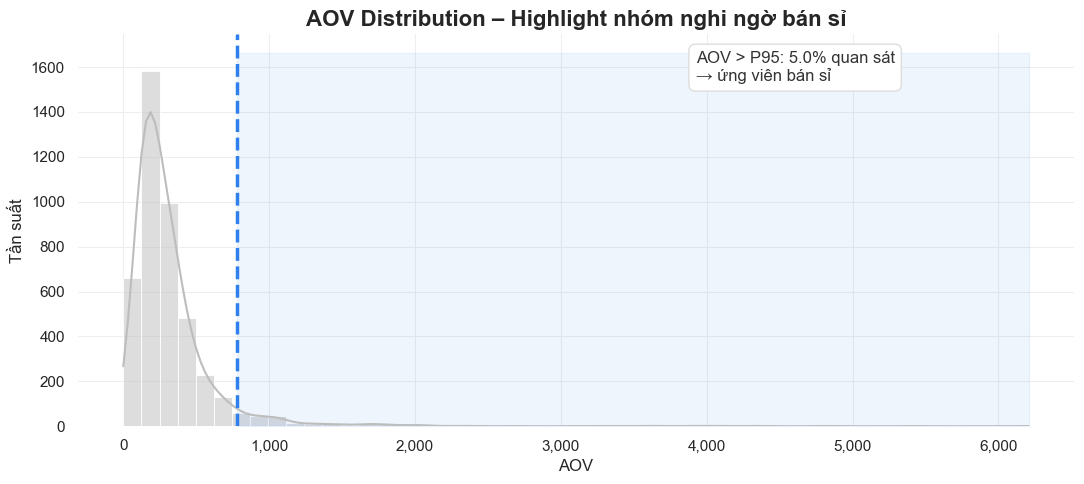

In [29]:
aov = df2["aov"].dropna()
p95 = np.percentile(aov, 95)

fig, ax = plt.subplots()

sns.histplot(aov, bins=50, kde=True, color=NEUTRAL, edgecolor="white", linewidth=0.6, ax=ax)

# Tô vùng wholesale zone
ymin, ymax = ax.get_ylim()
ax.fill_betweenx([ymin, ymax], p95, aov.max(), color=ACCENT, alpha=0.08, label="Wholesale zone (AOV > P95)")
ax.axvline(p95, color=ACCENT, lw=2.5, ls="--")

# Tính % nằm trong zone
share = (aov > p95).mean()
ax.text(
    0.62, 0.88,
    f"AOV > P95: {share:.1%} quan sát\n→ ứng viên bán sỉ",
    transform=ax.transAxes,
    fontsize=12, color=DARK,
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="#DDDDDD")
)

ax.set_title("AOV Distribution – Highlight nhóm nghi ngờ bán sỉ")

ax.set_xlabel("AOV")
ax.set_ylabel("Tần suất")
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [30]:
df2.columns

Index(['CustomerID', 'sum_revenue', 'sum_quantity', 'cnt_bill', 'aov'], dtype='object')

In [31]:
df2["qty_per_bill"] = df2.sum_quantity/df2.cnt_bill

  CustomerID  BuyerType
0      12347     Retail
1      12348  Wholesale
2      12349     Retail
3      12350     Retail
4      12352     Retail


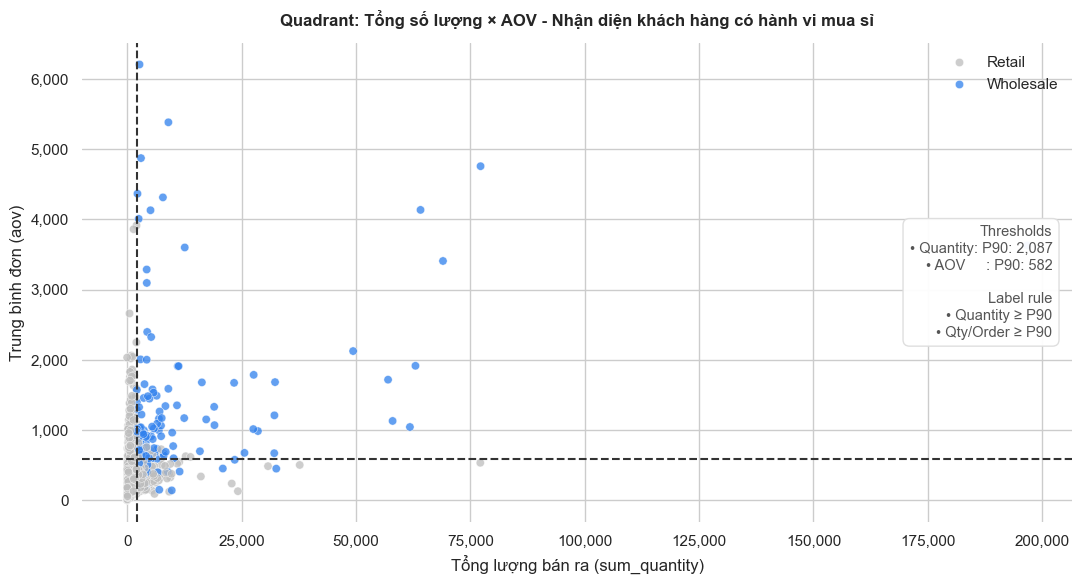

In [52]:
# =========================
# 0) Style
# =========================
sns.set_theme(style="whitegrid")
ACCENT  = "#2F80ED"
NEUTRAL = "#BDBDBD"
DARK    = "#333333"

# =========================
# 1) Copy + Validate columns
# =========================
d = df2.copy()

required_cols = ["CustomerID", "sum_quantity", "cnt_bill", "aov", "sum_revenue"]
missing = [c for c in required_cols if c not in d.columns]
if missing:
    raise ValueError(f"df2 thiếu cột: {missing}")

# =========================
# 2) Cleaning
# =========================
d = d.dropna(subset=required_cols).copy()

# Remove invalid / non-positive values (refunds, errors)
d = d[
    (d["sum_quantity"] > 0) &
    (d["cnt_bill"] > 0) &
    (d["aov"] > 0) &
    (d["sum_revenue"] > 0)
].copy()

# Extra features
d["qty_per_bill"] = d["sum_quantity"] / d["cnt_bill"]      # average quantity per order
d["unit_price"]   = d["sum_revenue"]  / d["sum_quantity"]  # avg unit price

# Handle inf and remaining NaNs
d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=["qty_per_bill", "unit_price"])

# =========================
# 3) Thresholds (Quadrant method)
# =========================
q = 0.90  # 0.90 = top 10% (wider), 0.95 = top 5% (stricter)

qty_thr = d["sum_quantity"].quantile(q)   # High Quantity threshold (x-axis)
aov_thr = d["aov"].quantile(q)            # High AOV threshold (y-axis)
qpb_thr = d["qty_per_bill"].quantile(q)   # High qty-per-bill threshold (optional for stricter Wholesale)

# =========================
# 4) Quadrant label (for explanation/debug)
# =========================
conditions = [
    (d["sum_quantity"] >= qty_thr) & (d["aov"] >= aov_thr),
    (d["sum_quantity"] <  qty_thr) & (d["aov"] >= aov_thr),
    (d["sum_quantity"] <  qty_thr) & (d["aov"] <  aov_thr),
    (d["sum_quantity"] >= qty_thr) & (d["aov"] <  aov_thr),
]
choices = [
    "Q1: HighQty-HighAOV",
    "Q2: LowQty-HighAOV",
    "Q3: LowQty-LowAOV",
    "Q4: HighQty-LowAOV",
]
d["quadrant"] = np.select(conditions, choices, default="Unknown")

# =========================
# 5) Final label in English: BuyerType (Wholesale/Retail)
#    - Strict version (recommended): High total quantity AND high qty_per_bill
#    - If you want pure quadrant-only: use d["quadrant"].isin(["Q1...", "Q4..."])
# =========================
d["BuyerType"] = np.where(
    (d["sum_quantity"] >= qty_thr) & (d["qty_per_bill"] >= qpb_thr),
    "Wholesale",
    "Retail"
)

# Output df: 2 columns only
cust_label_df = (
    d[["CustomerID", "BuyerType"]]
    .drop_duplicates("CustomerID")
    .reset_index(drop=True)
)

print(cust_label_df.head())

# =========================
# 6) Plot: Scatter with quadrant thresholds
# =========================
fig, ax = plt.subplots(figsize=(11, 6))

sns.scatterplot(
    data=d,
    x="sum_quantity",
    y="aov",
    hue="BuyerType",
    palette={"Wholesale": ACCENT, "Retail": NEUTRAL},
    alpha=0.75,
    edgecolor="white",
    linewidth=0.4,
    ax=ax
)

# Threshold lines
ax.axvline(qty_thr, color=DARK, ls="--", lw=1.5)
ax.axhline(aov_thr, color=DARK, ls="--", lw=1.5)

# Title + subtitle storytelling (English)
ax.set_title("Quadrant: Tổng số lượng × AOV - Nhận diện khách hàng có hành vi mua sỉ", pad=12)
subtitle = (
    f"Thresholds\n"
    f"• Quantity: P{int(q*100)}: {qty_thr:,.0f}\n"
    f"• AOV     : P{int(q*100)}: {aov_thr:,.0f}\n\n"
    f"Label rule\n"
    f"• Quantity ≥ P{int(q*100)}\n"
    f"• Qty/Order ≥ P{int(q*100)}"
)

ax.text(
    0.98, 0.50, subtitle,                      # center right
    transform=ax.transAxes,
    ha="right", va="center",
    fontsize=10.5, color="#555555",
    linespacing=1.25,
    bbox=dict(boxstyle="round,pad=0.45",
              facecolor="white", edgecolor="#DDDDDD", alpha=0.95)
)
# Axis labels + formatting
ax.set_xlabel("Tổng lượng bán ra (sum_quantity)")
ax.set_ylabel("Trung bình đơn (aov)")
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

# Optional: if sum_quantity is extremely skewed
# ax.set_xscale("log")

ax.legend(title="", frameon=False, loc="upper right")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [48]:
# =========================
# 7) Quick sanity checks (optional)
# =========================
print("\nBuyerType distribution (%):")
print(cust_label_df["BuyerType"].value_counts(normalize=True).mul(100).round(2))

print("\nThresholds used:")
print({
    "q": q,
    "qty_thr": qty_thr,
    "aov_thr": aov_thr,
    "qpb_thr": qpb_thr
})


BuyerType distribution (%):
BuyerType
Retail       96.45
Wholesale     3.55
Name: proportion, dtype: float64

Thresholds used:
{'q': 0.9, 'qty_thr': np.float64(2087.3999999999996), 'aov_thr': np.float64(582.2439999999999), 'qpb_thr': np.float64(366.2799999999999)}


In [56]:
d[["CustomerID", "BuyerType"]].drop_duplicates().to_csv("buyer_type.csv", index=False)